In [7]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's try to apply the DLT again, but this time with some normalization on corners.

- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:bali_3d_reconstruction_using_dlt.pdf
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:ece4580_t03_calibration.pdf
- https://rpg.ifi.uzh.ch/docs/teaching/2020/03_camera_calibration.pdf
- https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-ipr.2019.1489
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

Let's perform non-linear optimization to find the best parameters for the DLT.

$$
P = argmin_{K, RT, \rho} \sum_{i=1}^{n} 
    \left\| 
        \mathbf{x}_i - \pi(\mathbf{X}_i, RT, K, \rho)
    \right\|^2
$$

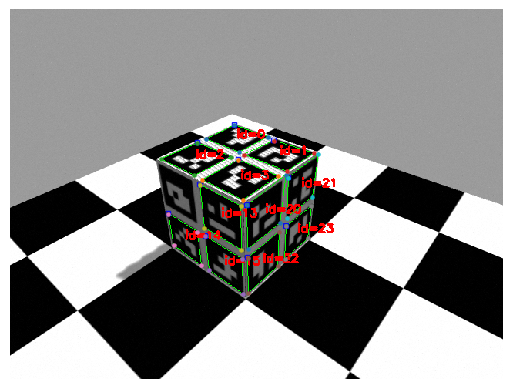

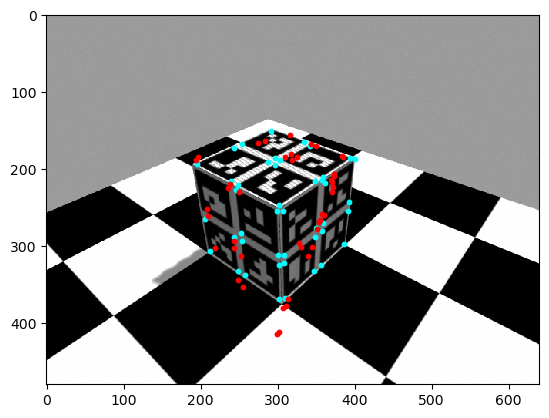

In [44]:
import cv2 as cv
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path
import numpy as np
from IPython.display import display

from camera import (
    move_camera_pos,
    get_camera_image_rgb,
    get_camera_image_depth,
    draw_aruco_grid,
    extract_aruco_tags,
    draw_aruco_tags_corners,
    map_id_to_world_coords_corners,
    compute_dlt,
)
import rospy


rospy.init_node("camera_test")

move_camera_pos(-0.4, -0.4, 1, pitch=0.6, yaw=0.7)
rgb = get_camera_image_rgb()
frame_markers, corners, ids = extract_aruco_tags(rgb)
draw_aruco_tags_corners(frame_markers, corners, ids)
plt.show()

ids = ids.reshape(-1)
mapping = map_id_to_world_coords_corners(
    border=10, width=175, total=400, side_length=0.2
)
xyz, uv = mapping[ids].reshape(-1, 3), np.array(corners).reshape(-1, 2)

P = compute_dlt(xyz, uv)

# let's reproject the points and see if they are close to the original ones
Z = P @ np.vstack([xyz.T, np.ones(len(xyz))])
Z = (Z / Z[2]).T

plt.imshow(rgb)
plt.scatter(uv[:, 0], uv[:, 1], c="cyan", s=10)
plt.scatter(Z[:, 0], Z[:, 1], c="red", s=10)
plt.show()

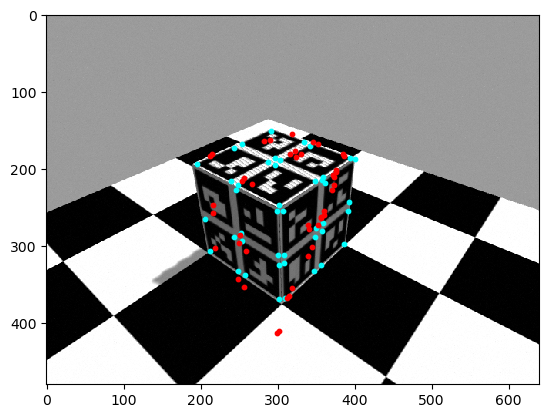

In [60]:
from scipy.optimize import least_squares
from functools import partial
from scipy.linalg import qr


def plot_estimated(rgb, uv, xyz, RT, K, rho):
    K = K.copy()
    K[0, 2] = rho
    Z = (RT @ K) @ np.vstack([xyz.T, np.ones(len(xyz))])
    Z = (Z / Z[2]).T
    plt.imshow(rgb)
    plt.scatter(uv[:, 0], uv[:, 1], c="cyan", s=10)
    plt.scatter(Z[:, 0], Z[:, 1], c="red", s=10)
    plt.show()


def fun(rho, uv, xyz, RT, K):
    K = K.copy()
    K[0, 2] = rho
    Z = (RT @ K) @ np.vstack([xyz.T, np.ones(len(xyz))])
    Z = (Z / Z[2]).T
    err = (np.linalg.norm(uv - Z[:, :2]) ** 2).sum()
    return err


RT, K = qr(P)
assert np.allclose(RT @ K, P)
res = least_squares(partial(fun, uv=uv, xyz=xyz, RT=RT, K=K), 0, method="lm")
plot_estimated(rgb, uv, xyz, RT, K, res.x)

In [59]:
# let's create a gif from the points
# needs gifsicle and pygifsicle, as well as imageio
import imageio
import tempfile
import tqdm
from pygifsicle import optimize


def generate_gif(rgb, uv, Z, name):
    with tempfile.TemporaryDirectory() as tmpdir:
        plt.imshow(rgb)
        for i in tqdm.tqdm(range(len(uv))):
            plt.scatter(uv[i, 0], uv[i, 1], c="cyan", s=10)
            plt.scatter(Z[i, 0], Z[i, 1], c="red", s=10)
            plt.savefig(Path(tmpdir) / f"{i:03d}.png")
        plt.close()
        images = [imageio.v2.imread(p) for p in sorted(Path(tmpdir).glob("*.png"))]
        imageio.mimsave(name, images, fps=2)
        optimize(name)


generate_gif(rgb, uv, Z, "../media/20230129-00-calibration-reprojection.gif")

100%|██████████| 44/44 [00:31<00:00,  1.42it/s]


In [97]:
# let's make a gif plotting the mapping points in 3d
# 3d plotting
from mpl_toolkits.mplot3d import Axes3D

name = "../media/20230129-01-world-draw-order.gif"
with tempfile.TemporaryDirectory() as tmpdir:
    p = mapping.reshape(-1, 3)
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={"projection": "3d"})
    for i in range(4):
        axes.flatten()[i].view_init(azim=30 + i * 90, elev=30)

    plt.tight_layout()
    # each of the the cube gets a different color; these are in groups of 16
    counter = 0
    for i in tqdm.tqdm(range(6)):
        for j in range(4):
            s = i * 16 + j * 4
            for k in range(4):
                e = s + k + 1
                for ax in axes.flatten():
                    ax.scatter(
                        p[s:e, 0],
                        p[s:e, 1],
                        p[s:e, 2],
                        c=f"C{i}",
                        label=f"face {i}",
                        s=10,
                    )
                    ax.plot3D(p[s:e, 0], p[s:e, 1], p[s:e, 2], c=f"C{i}")
                plt.savefig(Path(tmpdir) / f"{counter:03d}.png")
                counter += 1
    plt.close()
    images = [imageio.v2.imread(p) for p in sorted(Path(tmpdir).glob("*.png"))]
    imageio.mimsave(name, images, fps=5)
    optimize(name)

100%|██████████| 6/6 [06:23<00:00, 63.89s/it]
